In [1]:
# import required library
if (!require(dummies)) {
    install.packages("dummies")
}
if (!require(xgboost)) {
    install.packages("xgboost")
}
library(xgboost)
library(moments)  # skewness

Loading required package: dummies
dummies-1.5.6 provided by Decision Patterns

Loading required package: xgboost


In [2]:
# load the data set
train = read.csv('./train.csv')
test = read.csv('./test.csv')

# combine into one data frame
data = rbind(train[, -81], test)

# compute the number of missing values in each column
num.NA = colSums(apply(data[, -1], 2, is.na))
data.type = sapply(data[, names(which(num.NA != 0))], class)

# drop column of Alley, PoolQC, Fence, MiscFeature
drop.names = c("Alley", "PoolQC", "Fence", "MiscFeature")
data = data[ , !(names(data) %in% drop.names)]

# find all categorical and numerical variables
data.type = sapply(data[ , -1], class)
categorical.var = names(data)[which(c(NA, data.type, NA) == 'factor')]
numerical.var = names(data)[which(c(NA, data.type, NA) == 'integer')]

# create new feature named "NA" for categorical variables
for (i in categorical.var) {
    data[, i] = addNA(data[, i])
}

# create new feature using the median value for numerical variables
numerical.missing.var = c('LotFrontage', 'MasVnrArea', 'GarageYrBlt')
for (i in numerical.missing.var) {
    na.id = is.na(data[, i])
    tmp.median = median(train[, i], na.rm=TRUE)
    data[which(na.id), i] = tmp.median
}

# transform numerical feature whose skewness is larger than 0.75
skewed.features = sapply(data[, numerical.var], skewness)
skewed.features = numerical.var[which(skewed.features > 0.75)]
for (i in skewed.features) {
    data[, i] = log(data[, i] + 1)
}

# directly transform "Street", "Utilities" and "CentralAir" into 0-1 values
data[, 'Street'] = as.numeric(data[, 'Street']) - 1
data[, 'Utilities'] = as.numeric(data[, 'Utilities']) - 1
data[, 'CentralAir'] = as.numeric(data[, 'CentralAir']) - 1

# find new categorical variable to create dummy variables
categorical.var = names(which(sapply(data[, categorical.var], function(x) length(unique(x))) > 2))
dummy.var = data.frame(dummy.data.frame(data[, categorical.var], sep='.'))
data = cbind(data, dummy.var)

# drop original categorical variables
data = data[ , !(names(data) %in% categorical.var)]

data.train = data[1:nrow(train), ]
data.test = data[(nrow(train) + 1):nrow(data), ]

data.train['SalePrice'] = train$SalePrice

# transform the response variable into log scale
data.train$SalePrice = log(data.train$SalePrice + 1)

# xgboost model

In [3]:
# get x and y variables
train.y = as.numeric(data.train$SalePrice)
train.x = data.train[, c(-1, -291)]
train.x = apply(train.x, 2, as.numeric)

test.x = data.test[, -1]
test.x = apply(test.x, 2, as.numeric)

In [4]:
set.seed(100)
cv.dum = xgb.cv(data=train.x, label=train.y, nfold=5, max.depth=2, 
                eta=1, nround=10, objective='reg:linear')
cat('\n')
bst.dum = xgboost(data=train.x, label=train.y, max.depth=2, eta=1, 
                  nround=10, objective='reg:linear')

[1]	train-rmse:0.399375+0.004733	test-rmse:0.399298+0.018786 
[2]	train-rmse:0.247774+0.004589	test-rmse:0.253076+0.017702 
[3]	train-rmse:0.212437+0.004851	test-rmse:0.227975+0.015115 
[4]	train-rmse:0.197967+0.004579	test-rmse:0.217213+0.014913 
[5]	train-rmse:0.186223+0.006324	test-rmse:0.210608+0.012450 
[6]	train-rmse:0.177458+0.006189	test-rmse:0.204019+0.013405 
[7]	train-rmse:0.168980+0.005644	test-rmse:0.195784+0.011861 
[8]	train-rmse:0.164291+0.005647	test-rmse:0.195603+0.015103 
[9]	train-rmse:0.159002+0.006508	test-rmse:0.190105+0.014031 
[10]	train-rmse:0.154362+0.006522	test-rmse:0.187882+0.012233 

[1]	train-rmse:0.399390 
[2]	train-rmse:0.248025 
[3]	train-rmse:0.213762 
[4]	train-rmse:0.199496 
[5]	train-rmse:0.183718 
[6]	train-rmse:0.175831 
[7]	train-rmse:0.167734 
[8]	train-rmse:0.161699 
[9]	train-rmse:0.156076 
[10]	train-rmse:0.152077 


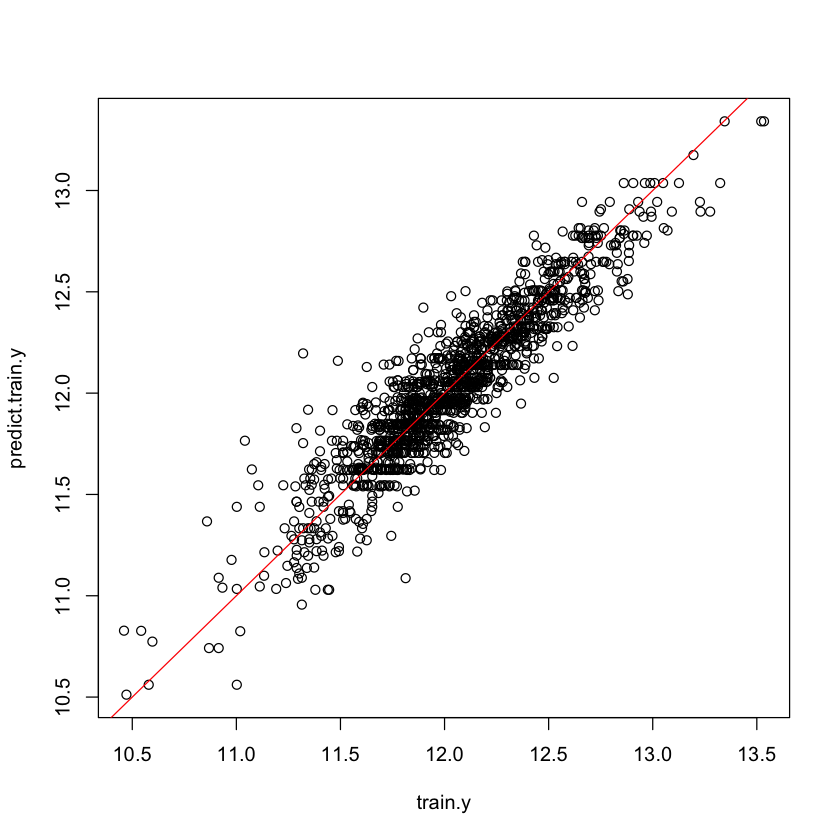

In [5]:
# predict on the training set
predict.train.y = predict(bst.dum, train.x)
plot(train.y, predict.train.y)
lines(x = c(10,14), y = c(10,14), col='red')

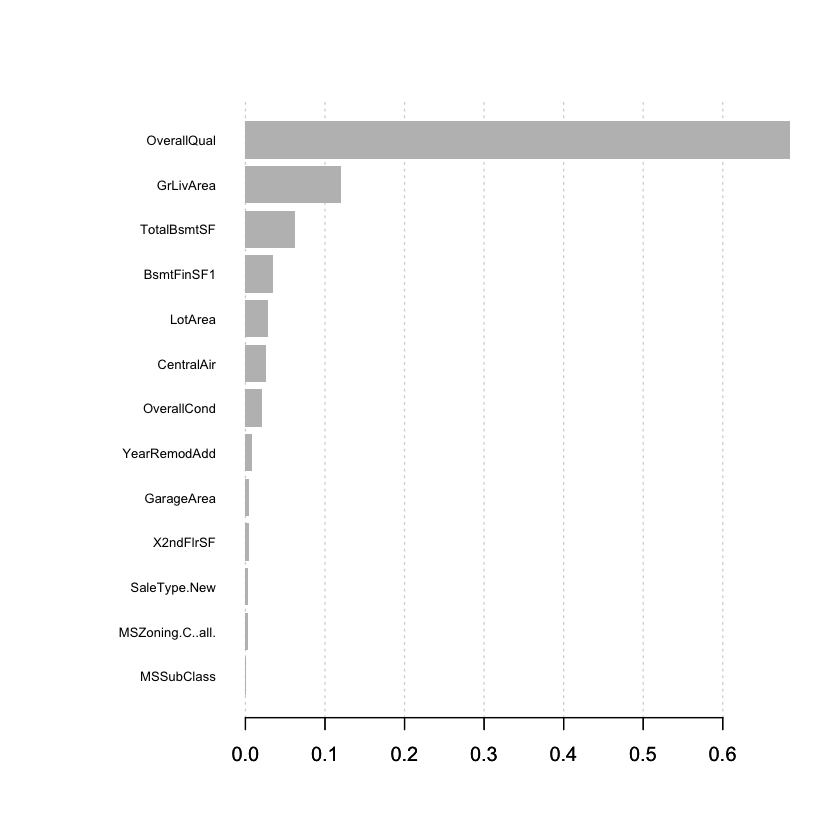

In [6]:
importance_matrix = xgb.importance(names(data.train[, c(-1, -291)]), model=bst.dum)
xgb.plot.importance(importance_matrix)

In [7]:
predict.test.y = predict(bst.dum, test.x)
predict.test.y = exp(predict.test.y) - 1

In [8]:
submission = read.csv('./other/sample_submission.csv')
submission$SalePrice = predict.test.y
write.table(submission, './XGB_model.csv', row.names = FALSE, sep = ',')